In [19]:
# imports
import sys

import numpy as np
import gzip
import json

import matplotlib.pyplot as plt
%matplotlib inline
from transitions import Machine

from IPython.display import display, Image

sys.path.append('./')
from maps import AbstractMap, ADEMap
from mapworld import MapWorld, MapWorldWrapper

# An Environment: MapWorld

This notebook gives an introduction into MapWorld, and environment for exploring dialogue and vision.

MapWorld is based on the metaphor of a *map* which places and connects *rooms* along the cardinal directions (north, south, etc.), and *agents* which move from room to room on this map. This is a bit like in the text adventures of yore, where on entering a new room you would be getting a textual description of the room; in MapWorld, you might instead be getting an image that represents the room.

The "rooms" don't have to represent actual physical *rooms* and could also be outdoor scenes; the aspect that the metaphor captures is that they are discrete places that are separated from each other, where a single navigation action (going in one direction) takes the agent from one place to another. This discretisation of movements distinguishes MapWorld from many of the environments that have recently been created for similar uses, where continuous movement is possible. MapWorld simplifies the problem, compared to these.

Various games can be defined in the MapWorld environment, focussing on different aspects of language and dialogue understanding. 


## The Maps

The data structure that defines the environment is the map. We randomly sample maps through a two step process. First, a layout is created that places (as yet untyped) rooms on the map.

### The Abstract Map / Room Layout

`AbstractMap` is the base class for creating these layouts. (Mathematically, these are connected subgraph of a two-dimensional grid graph.) 

In [20]:
this_map = AbstractMap(4,4,10)

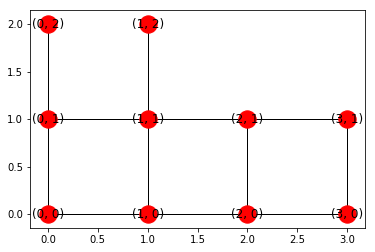

In [21]:
this_map.plot_graph()

`AbstractMap(n, m, n_rooms)` creates a graph by first initialising a matrix (of size `(n, m)`). It then randomly chooses a cell and creates a room there. From there, a random walk is initiated, creating new rooms until the desired number of rooms, `n_rooms`, has been reached.

While an agent could already navigate along such a map, this wouldn't be terribly interesting. The world takes shape when we assign additional information to the nodes. This information has to come from somewhere; we describe a variant here that takes it from a specific corpus of images of scenes.

### ADE Maps

`ADEMap` inherits from the base class, adding methods for (randomly) assigning additional information. Specifically, it uses the ADE20k corpus (**REF**) to assign first place *types* and then *instances* of these (in the form of images). 

Here's an example, showing the place types assigned to a (randomly sampled) layout.

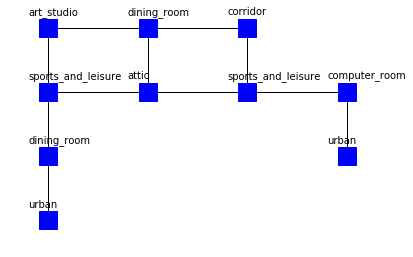

In [22]:
ade_map = ADEMap(4, 4, 10, (2,2))
ade_map.plot_graph()

The first three parameters of the `ADEMap` constructor have the same semantics as for `AbstractMap` (from which they are inherited).

The last parameter (here, `(2, 2)`) controls the amount of "ambiguity" on the type level, ensuring that certain types are repeated. In this particular implementation, these types are from a subset of the available types which we selected for plausibility to occur in a residential dwelling (which, as we hypothesise, influences how easily they can be named). The setting `(2, 2)` then ensures that two types come from this set, and are each repeated twice on the map. This creates some uncertainty on the type level, where naming the type of a room does not uniquely identify it. This is desirable for some of the games described below.

Additionally, we have identified some plausible *outdoor* place types, from which the types of nodes on the map that have only one edge are sampled. (Think of these rooms as entries to the house.)

In a final step then, instances (images) are sampled for each room, according to its type. The result can be shown with the method `.print_mapping()`:

In [23]:
ade_map.print_mapping()

(3, 2): work_place/computer_room    work_place/computer_room/ADE_train_00023132.jpg
(3, 1): urban/chicken_farm__outdoor urban/chicken_farm__outdoor/ADE_train_00005461.jpg
(2, 2): sports_and_leisure/jacuzzi__indoor sports_and_leisure/jacuzzi__indoor/ADE_train_00009921.jpg
(1, 2): home_or_hotel/attic         home_or_hotel/attic/ADE_train_00001906.jpg
(2, 3): work_place/corridor         work_place/corridor/ADE_train_00023175.jpg
(1, 3): home_or_hotel/dining_room   home_or_hotel/dining_room/ADE_train_00007061.jpg
(0, 3): cultural/art_studio         cultural/art_studio/ADE_train_00001748.jpg
(0, 2): sports_and_leisure/jacuzzi__indoor sports_and_leisure/jacuzzi__indoor/ADE_train_00009924.jpg
(0, 1): home_or_hotel/dining_room   home_or_hotel/dining_room/ADE_train_00006872.jpg
(0, 0): urban/parking_garage__outdoor urban/parking_garage__outdoor/ADE_train_00022028.jpg


The object provides further representations of the map, in particular a full json version that can be written out and read in for serialisation of the map (via `.to_json()` and `.from_json()`, respectively). 

There is also a special kind of JSON format which interprets the graph as a finite state machine with the edges being transitions triggered by navigation events corresponding to the appropriate cardinal directions. Here are some excerpts of this representation for our example:

In [24]:
ade_map.to_fsa_def()['nodes'][:3], ade_map.to_fsa_def()['transitions'][:3]

([{'base_type': 'indoor',
   'type': 'work_place/computer_room',
   'target': False,
   'instance': 'work_place/computer_room/ADE_train_00023132.jpg',
   'id': (3, 2)},
  {'base_type': 'outdoor',
   'type': 'urban/chicken_farm__outdoor',
   'target': False,
   'instance': 'urban/chicken_farm__outdoor/ADE_train_00005461.jpg',
   'id': (3, 1)},
  {'base_type': 'indoor',
   'type': 'sports_and_leisure/jacuzzi__indoor',
   'target': True,
   'instance': 'sports_and_leisure/jacuzzi__indoor/ADE_train_00009921.jpg',
   'id': (2, 2)}],
 [{'source': '(3, 2)', 'dest': '(3, 1)', 'trigger': 's'},
  {'source': '(3, 1)', 'dest': '(3, 2)', 'trigger': 'n'},
  {'source': '(3, 2)', 'dest': '(2, 2)', 'trigger': 'w'}])

We only note here that since the ADE corpus is fairly deeply annotated, we could also consider represent the rooms *symbolically* via that annotation, instead of through the images, or with a mixed representation (e.g. the images with the objects in it segmented out).

With this in hand, we can finally enter the MapWorld.

## Hello, (Map) World!

The MapWorld is realised by an object that takes a map (in the json format described above) and executes the state machine described by it, thus representing the agent navigating the map. After each state change, the environment returns a response describing the current state. 

Which aspects of the state (the node of the graph / room of the map) are returned can be controlled by a list of keys into the node dictionary. In the followng example, the fields `instance` and `type` are returned, together with information about which transitions are available from the new state (which may be the old state, in case a non-existing transition had been tried).

In [25]:
mw = MapWorld(ade_map.to_fsa_def(), ['instance', 'type'])

In [26]:
state_description = mw.try_transition('n')
state_description

({'instance': 'work_place/computer_room/ADE_train_00023132.jpg',
  'type': 'work_place/computer_room'},
 ['s', 'w'])

In [27]:
mw.try_transition(state_description[1][0])  # try the first available transition

({'instance': 'urban/chicken_farm__outdoor/ADE_train_00005461.jpg',
  'type': 'urban/chicken_farm__outdoor'},
 ['n'])

As this is a bit unwieldy, we also provide a wrapper around this object which uses the capabilities of the jupyter notebook to actually display the images. (This requires availability of the ADE20k corpus; you will at least have to adapt the path below.)

In [28]:
ade_path = '../../ADE20K_2021_17_01/images/ADE/training'

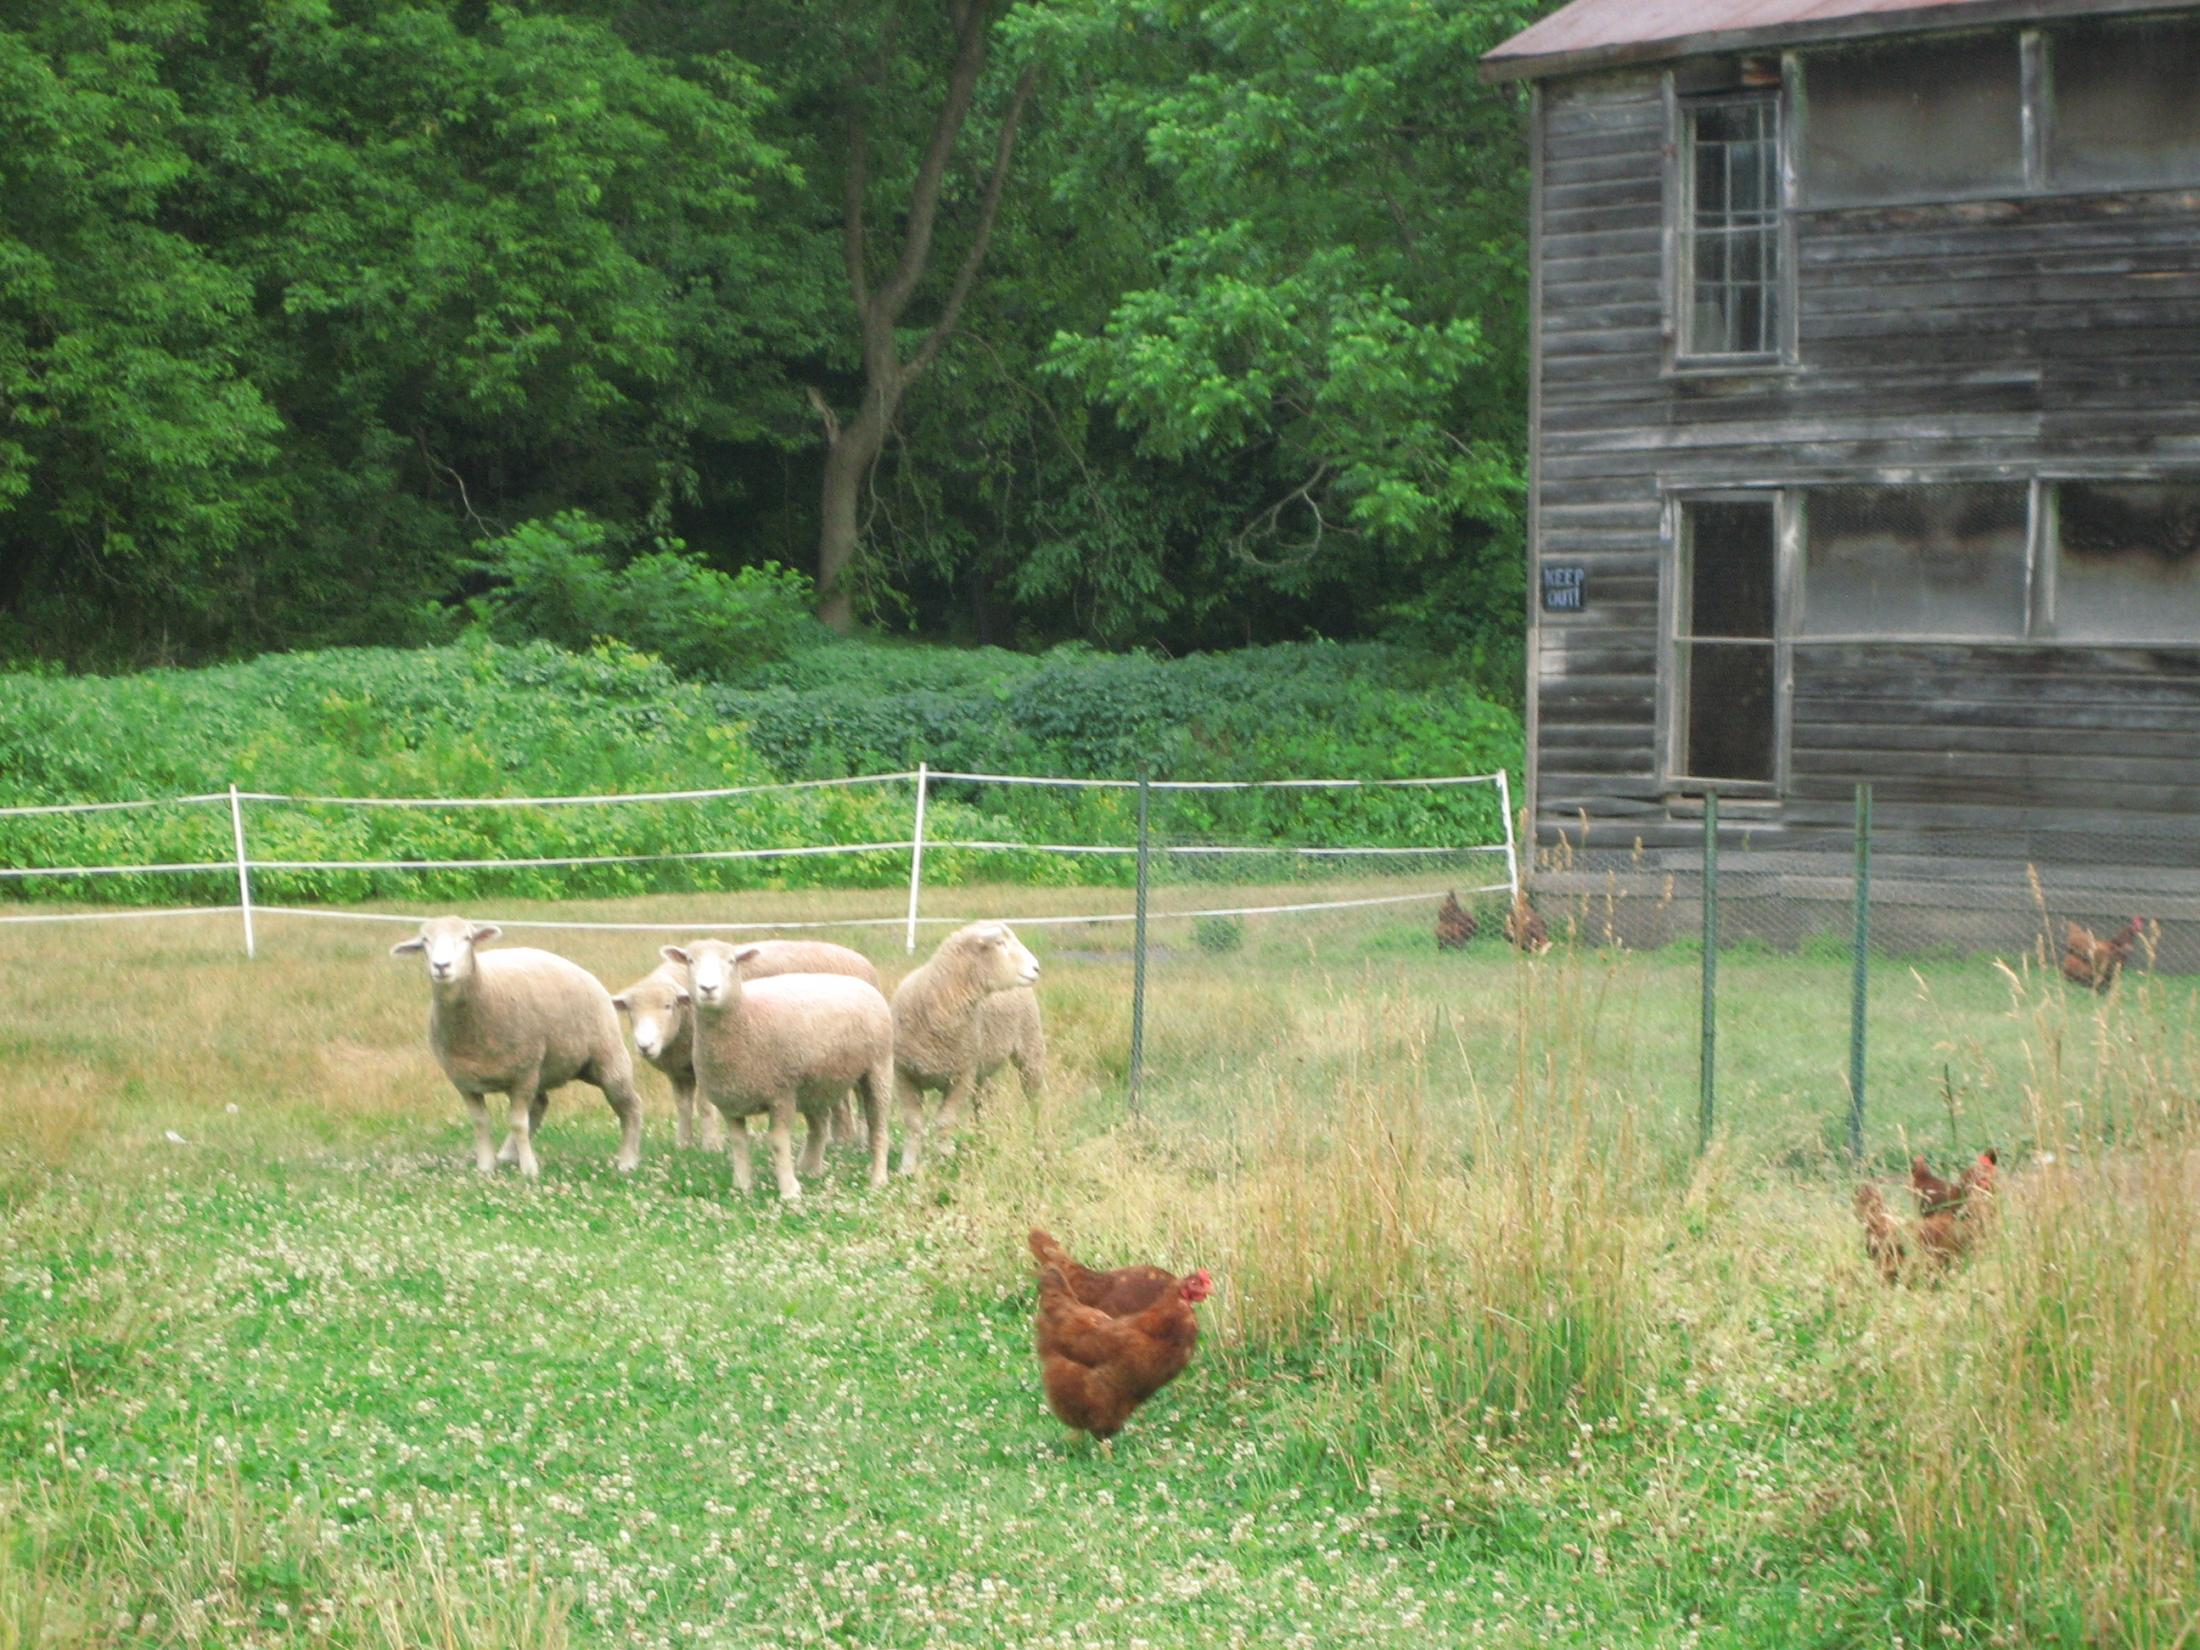

You can go: n


In [29]:
mww = MapWorldWrapper(ade_map, show_image=True, image_prefix=ade_path)

In [30]:
mww.upd('s')

Nothing happened.
{'instance': 'urban/chicken_farm__outdoor/ADE_train_00005461.jpg'}
You can go: n


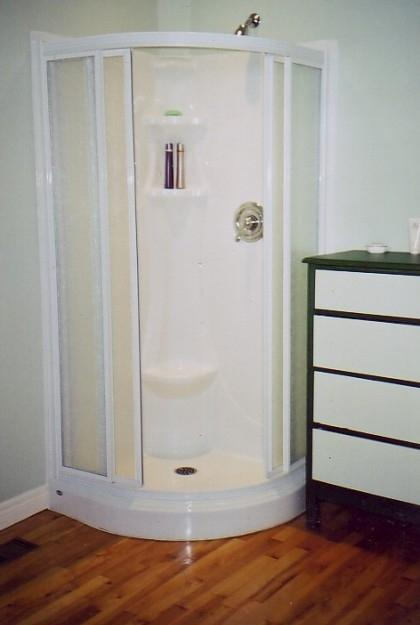

You can go: s w


In [13]:
mww.upd('e')

This object also implements a plot function that shows the map with the current position marked:

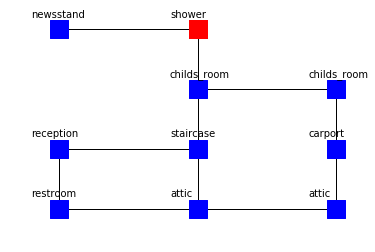

In [14]:
mww.plt()

# Some MapWorld Games

As much fun as it is to look at the maps in that way, the real use of this only comes with the definition of tasks to be done in this environment that require the use of language and interaction. Here we describe some ideas for such tasks, organised according to whether only one agent is in the environment or both agents are.

## Single Agent Games

We first note that we can set up some games that do not require language at all, or at least very little. These tasks could be used to familiarise oneself with reinforcement learning techniques:

* Train agent that learns to explore a map fully (i.e., visit all rooms). Agent needs to interpret verbal feedback from environment ("available directions: s, e, w") to know which of the actions it is capable of performing are appropriate, and needs to learn to assemble some representation of the map, to know when to decide that it has seen all rooms. Action space: the cardinal directions, plus "done". Reward is given after "done", some high positive number if all rooms visited, minus penalty for each action. Large negative reward if not all visited.
* Find first room of a given type. (In that sense, this is a reduced version of the task described in the next section.) Agent needs to learn to navigate and additionally also to classify images into scene types.

## One Agent in MapWorld, One Agent Remote

This setup naturally introduces some asymmetry, in that only one agent can navigate. (Let's call this agent the *ground agent*.) To introduce a need for communication, we can give some priviledged information to the other agent (let's call this the *director*). For example, the director could receive information about the desired goal (by being shown an image, or being given a textual description) to which the ground agent must navigate. If the communication channel is only verbal, the ground agent needs to be able to produce verbal descriptions of what it sees, for the director to match with the goal state.

Here is an example. We first sample another map, and randomly select one of its rooms as target.

In [15]:
ade_map = ADEMap(4, 4, 10, (2,2))

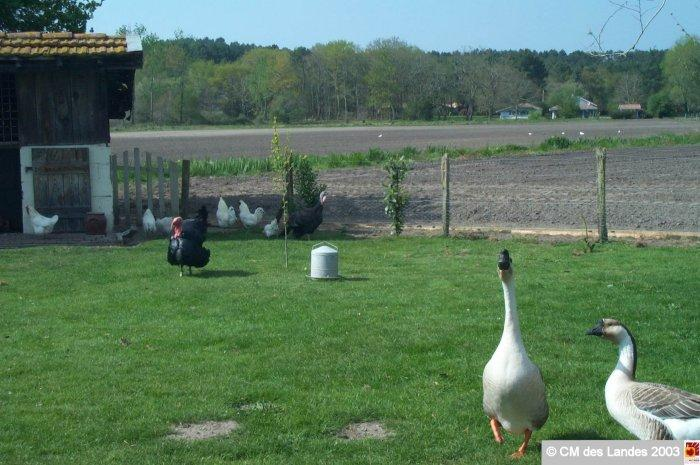

In [16]:
target_image = np.random.choice(ade_map.to_fsa_def()['nodes'])['instance']
target_image = ade_path + '/' + target_image
display(Image(target_image, width=400, height=400))

This *mission description* ("move to *this* place") might trigger the director to produce something like the following as instruction / information for the ground agent:
> Director: *We are looking for an outside view of a strange modernist building, sort of like a box sitting on top of another building.*

(This will most likely *not* fit what you are seeing, as the map is randomly sampled each time the notebook is executed. It is just meant to illustrate the kinds of utterance that can be expected here.)

This basic setting can be developed in various directions, depending on what kind of interaction is allowed and on which of the agents has to make the final decision on whether the goal has been reached (or whether they need to make it together).

* In the most basic variant of this setting, the ground agent is not allowed to respond and would need to try to find the room only on the basis of the single description it received. Thus, the task reduces to something like "caption interpretation" plus navigation plus deciding whether a match is found, and no model for the director is required; which makes it a nice first task for trying out methods like reinforcement learning.

* In more interactive variants, the ground agent can reply verbally. Various additional language-based capabilities would then come in handy for the ground agent: *reporting* what it sees; asking for *clarification* of a description, in order to better match it with what it sees; or *answering* targeted questions of the director. The extent to which these are available will influence the best strategy for reaching the goal. E.g., if the ground agent can only *report* (and understand navigation commands), the director can use this to "remote control" it and steer it to a likely target state. If the ground agent can clarify, it can take a more independent approach an navigate until the first likely candidate room is found and then request targeted information that might confirm or reject the hypothesis.

In these tasks, both roles, ground agent and director, are interesting targets for modelling computationally, each placing slightly different emphasis on component capabilities.

* Instead of specifying a full scene, the goal can also be to find particular kinds of objects. ("Find the refridgerator." or "what colour is the refridgerator?", cf. the recently introduced task of "embodied visual question answering".) Such goals could be derived automatically from the available object annotation (and hence this game would not require additional data collection efforts). (For this task, however, manual effort in designing plausible maps might be advisable, for the agent to be able to learn and use knowledge about likely room configurations with e.g. a kitchen next to the living room, rather than being next to the jacuzzi.) [Or should this task be in the previous section?]

### Both Agents in MapWorld

We can also define games where both participants are placed on the map. The goal given to them could then simply be to **meet up** (that is, to be in the same room, and to know that this is the case without being told by the environment; to constrain this a bit, the instruction can be to meet up in a room of a certain type). (See \cite{schlangen:sivl18}, \cite{schlangen:aix}, \cite{ilinykh:inlg18}.)

This requires capabilities that are also needed for the settings described in the previous section, but additionally, it requires *coordination* of the agents. They need to decide on a strategy (first one to find a potentially meetup room waits for the other?) and need to come to an agreement on whether they are indeed in the same room.

(Technically, this setting can be realised by running two environments on the same map and enabling a communication channel between the players. To test it, you can serialise a map to disk, load it on two computers as described here, and simply talk. We also provide a full-scale web application in which this can be set up; instructions for using this will be provided separately.)

As a limiting case of this setting (which can also be seen as a limiting case of the previously described director / ground agent setting), the task for the agents can simply be to decide whether they are in the same room or not (**match it**), thus taking away the navigation task. (In which case the metaphor or "rooms" and "maps" would not be required and the task can simply be formulated as "try to come to an agreement on whether you are looking at the same image or not".)

Here's an example of two randomly sampled images from the same category.

In [17]:
# load up instance list 
with gzip.open('ade_cat_instances.json.gz', 'rb') as f:
    cat_instances_bytes = f.read()
    cat_instances_str = cat_instances_bytes.decode('utf-8')
    cat_instances = json.loads(cat_instances_str)

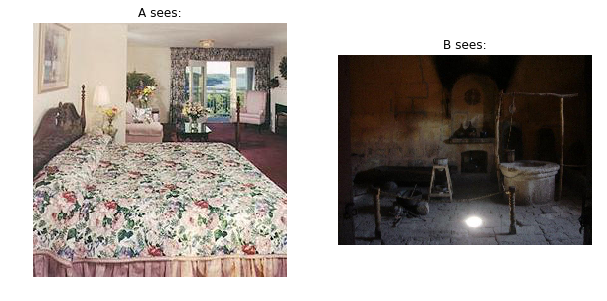

In [18]:
# two example bedrooms   
ba, bb = np.random.choice(cat_instances['b/bedroom'], 2, replace=False)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(plt.imread(ade_path + '/' + ba))
ax[0].set_title('A sees:')
ax[1].imshow(plt.imread(ade_path + '/' + bb))
ax[1].set_title('B sees:')
ax[0].axis('off')
ax[1].axis('off');

Some observations / variants:

* If no interaction is allowed and only one player gives a description, this is *caption interpretation*. (With the decision being made by the interpreter.)
* If interaction is restricted to polar questions, this is *visual question answering* (but with a purpose). Could be uni-directional (one is questioner, other is answerer), or bi-directional with taking turns. Burden of making the decision could be on one designated agent,  or on both.
* If full dialogical interaction is allowed, the task comprises both these capabilities, but the linguistic form might be more reduced (less obvious questions; indirect answers).

# References

(<a id="cit-schlangen:sivl18" href="#call-schlangen:sivl18">Schlangen, Ilinykh <em>et al.</em>, 2018</a>) D. Schlangen, N. Ilinykh and S. Zarrieß, ``_Visual  Dialogue  Needs  Symmetry,  Goals,  andDynamics:  The  Example  of  the  MeetUp  Task_'', Proceedings of the 1st Workshop on Shortcomings in Vision and Language (SiVL) at ECCV 2018,  2018.

(<a id="cit-schlangen:aix" href="#call-schlangen:aix">Schlangen, Ilinykh <em>et al.</em>, 2018</a>) D. Schlangen, N. Ilinykh and S. Zarrieß, ``_MeetUp! A Task For Modelling Visual Dialogue_'', Short Paper Proceedings of the 22nd Workshop on the Semantics and Pragmatics of Dialogue (AixDial / semdial 2018),  2018.

(<a id="cit-ilinykh:inlg18" href="#call-ilinykh:inlg18">Ilinykh, Zarrieß <em>et al.</em>, 2018</a>) N. Ilinykh, S. Zarrieß and D. Schlangen, ``_The Task Matters. Comparing Image Captioning and Task-Based Dialogical Image Description_'', Proceedings of 11th International Conference on Natural Language Generation (INLG 2018),  2018.

